<a href="https://colab.research.google.com/github/yfwang09/ShElastic/blob/master/examples/Test01_SH_Gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gradient of Spherical Harmonics in Cartesian Coordinates

This notebook is served as a test case of `shgrad` module, and the derivation of the gradient of spherical harmonics based on Hobson's differentiation (Hobson, 1931).

### Setup of the code and run this test

Please run through the notebook by clicking **Kernel/Restart & Run All**, and the test result is shown at the very end of the notebook. You can change the following flag to control whether you want to visualize the spectrum of spherical harmonics.

In [1]:
show_spectrum = True

In [2]:
# If you run this notebook on colab, run this cell
import os
codepath = '/content/ShElastic'
if not os.path.exists(codepath):
    !git clone https://github.com/yfwang09/ShElastic.git 
    !pip install pyshtools==4.6.2
os.chdir(os.path.join(codepath, 'examples'))

Cloning into 'ShElastic'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 1227 (delta 76), reused 39 (delta 15), pack-reused 1081
Receiving objects: 100% (1227/1227), 151.70 MiB | 33.47 MiB/s, done.
Resolving deltas: 100% (462/462), done.
     |████████████████████████████████| 10.8MB 274kB/s 


### Hobson's Differentiation

For convenience, we first define unnormalized spherical harmonics:

$$
\chi_l^m(\theta, \varphi) = P_l^m(\cos\theta)e^{im\varphi}
$$

where $P_l^m$ is the unnormalized associate Legendre polynomial.

Then the irregular and regular solid harmonics defined based on unnormalized spherical harmonics:

$$
\mathcal{I}_l^m(r,\theta,\varphi) = 
\frac{(l-\left|m\right|)!}{r^{l+1}}\chi_l^m(\theta,\varphi);\quad
\mathcal{R}_l^m(r,\theta,\varphi) = 
\frac{r^{l}}{(l+\left|m\right|)!}\chi_l^m(\theta,\varphi)\quad(l\geq0,\left|m\right|\leq l)
$$

Then there are some simplified algebra relations:

$$
\mathcal{R}_l^{-m}(\mathbf{r})=(-1)^m\bar{\mathcal{R}}_l^m(\mathbf{r}) \quad
\mathcal{I}_l^{-m}(\mathbf{r})=(-1)^m\bar{\mathcal{I}}_l^m(\mathbf{r}) \\
\mathcal{R}_l^{m}(-\mathbf{r})=(-1)^l\mathcal{R}_l^m(\mathbf{r}) \quad
\mathcal{I}_l^{m}(-\mathbf{r})=(-1)^l\mathcal{I}_l^m(\mathbf{r}) \\
$$

and the Hobson's differentiation can be written as:

$$
D_1\mathcal{I}_l^m = \mathcal{I}_{l+1}^{m-1},\quad
D_2\mathcal{I}_l^m =-\mathcal{I}_{l+1}^{m+1},\quad
D_3\mathcal{I}_l^m =-\mathcal{I}_{l+1}^{m};  \\
D_1\mathcal{R}_l^m = \mathcal{R}_{l-1}^{m-1},\quad
D_2\mathcal{R}_l^m =-\mathcal{R}_{l-1}^{m+1},\quad
D_3\mathcal{R}_l^m = \mathcal{R}_{l-1}^{m}.  \\
$$

where $D_i$ are defined as:

$$
D_1 = \left({\partial\over\partial x}-i{\partial\over\partial y}\right),\quad
D_2 = \left({\partial\over\partial x}+i{\partial\over\partial y}\right),\quad
D_3 = {\partial\over\partial z}.
$$

For a better understanding of the derivative, we take some examples:

$$
\chi_1^{\pm1} = \sin\theta e^{\varphi} = \frac{x\pm iy}{r}, \quad
\chi_1^0 = \cos\theta = {z\over r}; \\
\mathcal{R}_1^{\pm1} = x\pm iy, \quad \mathcal{R}_1^{0} = z \\
\mathcal{I}_1^{\pm1} = \frac{x\pm iy}{r^3}, \quad \mathcal{I}_1^{0} = \frac{z}{r^3}
$$

We can see that the same $m$ level modes have the same $(x\pm iy)$ degrees, and $z$ degree is increasing with level $l$.
Similarly, $R_l^m$ and $R_{l+1}^{m+1}$ have the same $z$ degrees, and $(x\pm iy)$ degrees are increasing with level $l$.

Because of the mysterious sign convention and normalization conventions in SHTOOLS, here we develop a set of tools to evaluate the solid harmonics and take numerical derivatives on a 3D mesh.

In [3]:
import numpy as np
import sys, os
import time
sys.path.append('..')
from shelastic.shutil import CartCoord_to_SphCoord, SphCoord_to_CartCoord

We create a 3D meshgrid for numerically calculate the gradient:

In [4]:
# The order (Y,X,Z) makes sure that axis 0,1,2 corresponds to X,Y,Z
normalization='4pi'
# normalization='ortho'
# normalization='schmidt'
shtype = 'irr'
lmax = 6
xgrid = np.linspace(1, 3, 64)
Y, X, Z = np.meshgrid(xgrid, xgrid, xgrid)
R, THETA, PHI = CartCoord_to_SphCoord(X, Y, Z)
LAT = 90 - np.rad2deg(THETA)
LON = np.rad2deg(PHI)

Then we set up the SHTOOLS coefficient class:

kind = 'complex'
normalization = '4pi'
csphase = 1
lmax = 6
header = None


/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2068: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, :lmax] = _np.fliplr(mnegative)[:, :lmax]
/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2069: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, lmax:] = mpositive


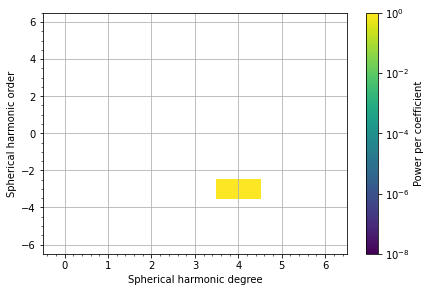

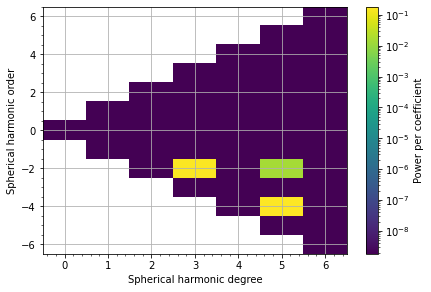

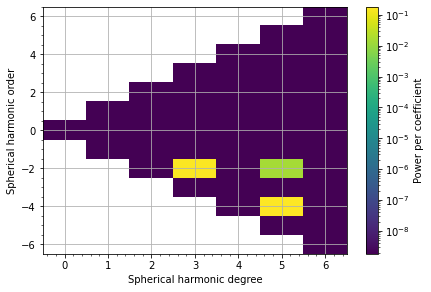

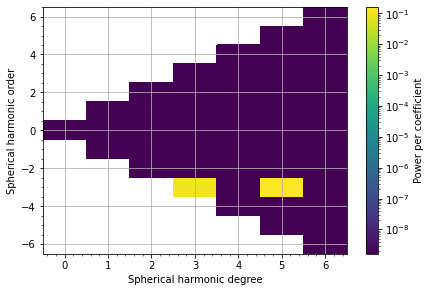

In [5]:
import pyshtools
import matplotlib.pyplot as plt
from shelastic.shgrad import VSH1

l = 4; m = -3;

clm = pyshtools.SHCoeffs.from_zeros(lmax=lmax,kind='complex',normalization=normalization)
clm.info()
clm.set_coeffs(1.0, l, m)
fig, ax = clm.plot_spectrum2d(vrange=(1e-8, 1))
for i in range(3):
    Ylm = pyshtools.SHCoeffs.from_array(VSH1(clm.to_array())[...,i])
    if show_spectrum:
        Ylm.plot_spectrum2d(vrange=(1e-8, 1))

And evaluate the spherical harmonics on the meshgrid in the next few blocks.

If you use the `expand` function provided by SHTOOLS and see `TypeError: can't convert complex to float`, please make the modification in SHTOOLS code `{PATH_TO_SHTOOLS}/shclasses/shcoeffsgrid.py`, line 2079, from

    values = _np.empty_like(lat, dtype=float)

to

    values = _np.empty_like(lat, dtype=_np.complex)

Newer version of SHTOOLS has already fixed this bug. To find `{PATH_TO_SHTOOLS}`:

In [6]:
import os, sys
import pyshtools

print(r'{PATH_TO_SHTOOLS} is', os.path.split(pyshtools.__file__)[0])

{PATH_TO_SHTOOLS} is /usr/local/lib/python3.6/dist-packages/pyshtools


First, we calculate the gradients of solid harmonics numerically:

In [7]:
# f = clm.expand(lat=LAT,lon=LON) does not work, we implement our own instead
from shelastic.shutil import eval_GridC

#Ilm_num = clm.expand(lat=LAT, lon=LON)/R**(l+1)
tic = time.time()
Ilm_num = eval_GridC(clm, LAT, LON, R, shtype=shtype)
dIlm_num = np.gradient(Ilm_num, X[:,0,0], Y[0,:,0], Z[0,0,:])
tIlm_num = time.time() - tic

Then we evaluate the Hobson's differentiation of z direction on the meshgrid. The normalization coefficients are calculated as following:

$$
C_{irr} = \frac{(l'-|m'|)!}{(l-|m|)!} \\
C_{schmidt} = \sqrt{\frac{(l'+|m'|)!(l-|m|)!}{(l'-|m'|)!(l+|m|)!}} \\
C_{4\pi} = \sqrt{\frac{2l+1}{2l'+1}}
$$

Calculate the coefficients for z direction gradients:

In [8]:
from scipy.special import factorial

l_dz = l+1; m_dz = m; 
C_dz = factorial(l_dz-np.abs(m_dz))/factorial(l-np.abs(m));
C_norm = np.sqrt(factorial(l_dz+np.abs(m_dz))*factorial(l-np.abs(m))/factorial(l_dz-np.abs(m_dz))/factorial(l+np.abs(m)))
C_4pi = np.sqrt((2*l+1)/(2*l_dz+1))
if normalization in ['4pi', 'ortho']:
    C_dz = C_dz*C_norm*C_4pi
elif normalization == 'schmidt':
    C_dz = C_dz*C_norm
else:
    print('normalization not defined')

kind = 'complex'
normalization = '4pi'
csphase = 1
lmax = 6
header = None


/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2068: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, :lmax] = _np.fliplr(mnegative)[:, :lmax]
/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2069: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, lmax:] = mpositive


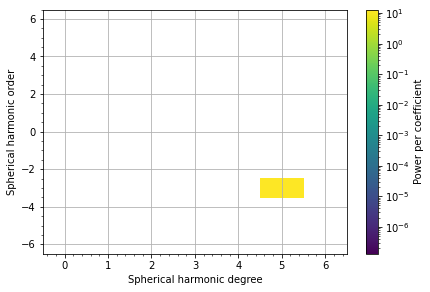

In [9]:
clm_dz = pyshtools.SHCoeffs.from_zeros(lmax=lmax,kind='complex',normalization=normalization)
clm_dz.info()
clm_dz.set_coeffs(-C_dz, l_dz, m_dz)
if show_spectrum:
    fig, ax = clm_dz.plot_spectrum2d(vrange=(1e-8, 1))

Then we evaluate the z-direction gradient on the same meshgrid:

In [10]:
# Ilm_dz = clm_dz.expand(lat=LAT, lon=LON)/R**(l_dz+1)
tic = time.time()
Ilm_dz = eval_GridC(clm_dz, LAT, LON, R, shtype=shtype)
tIlm_dz = time.time() - tic
#Ilm_dz = Ylm_dz/R**(l_dz+1)

Compare with the numerical (finite difference) results:

In [11]:
Cdz = (Ilm_dz/dIlm_num[2])#.mean()
errdz = np.abs(np.abs(Cdz).mean() - 1)
print(errdz)
Testdz = errdz < 1e-2
if Testdz:
    print('Single mode analytical dIlm/dz is close to numerical results, time: %.2fs'%(tIlm_dz))
else:
    print('Single mode analytical dIlm/dz is incorrect, rel. err.: %.8f, time: %.2fs'%(errdz, tIlm_dz))
# print(Cdz.mean())

0.006055982520895009
Single mode analytical dIlm/dz is close to numerical results, time: 5.72s


Then $D_1$ direction (${\partial\over\partial x}-i{\partial\over\partial y}$):

kind = 'complex'
normalization = '4pi'
csphase = 1
lmax = 6
header = None


/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2068: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, :lmax] = _np.fliplr(mnegative)[:, :lmax]
/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2069: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, lmax:] = mpositive


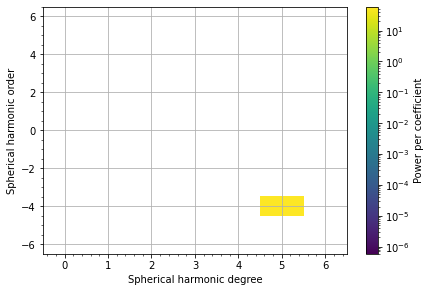

In [12]:
from scipy.special import factorial

l_d1 = l+1; m_d1 = m-1; C_d1 = factorial(l_d1-np.abs(m_d1))/factorial(l-np.abs(m));
C_norm = np.sqrt(factorial(l_d1+np.abs(m_d1))*factorial(l-np.abs(m))/factorial(l_d1-np.abs(m_d1))/factorial(l+np.abs(m)))
C_4pi = np.sqrt((2*l+1)/(2*l_d1+1))
if normalization in ['4pi', 'ortho']:
    C_d1 = C_d1*C_norm*C_4pi
elif normalization == 'schmidt':
    C_d1 = C_d1*C_norm
else:
    print('normalization not defined')

clm_d1 = pyshtools.SHCoeffs.from_zeros(lmax=lmax,kind='complex',normalization=normalization)
clm_d1.info()
clm_d1.set_coeffs(C_d1, l_d1, m_d1)
fig, ax = clm_d1.plot_spectrum2d(vrange=(1e-8, 1))

# Ilm_d1 = clm_d1.expand(lat=LAT,lon=LON)/R**(l_d1+1)
tic = time.time()
Ilm_d1 = eval_GridC(clm_d1, LAT, LON, R, shtype=shtype)
tIlm_d1 = time.time() - tic

Then $D_2$ direction (${\partial\over\partial x}+i{\partial\over\partial y}$):

kind = 'complex'
normalization = '4pi'
csphase = 1
lmax = 6
header = None


/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2068: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, :lmax] = _np.fliplr(mnegative)[:, :lmax]
/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2069: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, lmax:] = mpositive


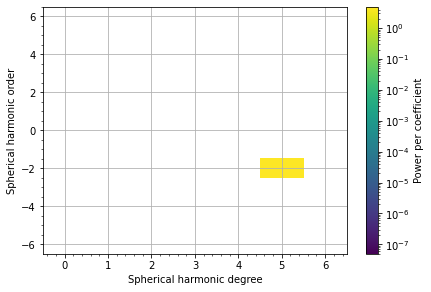

In [13]:
from scipy.special import factorial

l_d2 = l+1; m_d2 = m+1; C_d2 = factorial(l_d2-np.abs(m_d2))/factorial(l-np.abs(m));
C_norm = np.sqrt(factorial(l_d2+np.abs(m_d2))*factorial(l-np.abs(m))/factorial(l_d2-np.abs(m_d2))/factorial(l+np.abs(m)))
C_4pi = np.sqrt((2*l+1)/(2*l_d2+1))
if normalization in ['4pi', 'ortho']:
    C_d2 = C_d2*C_norm*C_4pi
elif normalization == 'schmidt':
    C_d2 = C_d2*C_norm
else:
    print('normalization not defined')

clm_d2 = pyshtools.SHCoeffs.from_zeros(lmax=lmax,kind='complex',normalization=normalization)
clm_d2.info()
clm_d2.set_coeffs(-C_d2, l_d2, m_d2)
fig, ax = clm_d2.plot_spectrum2d(vrange=(1e-8, 1))

# Ilm_d2 = clm_d2.expand(lat=LAT,lon=LON)/R**(l_d2+1)
tic = time.time()
Ilm_d2 = eval_GridC(clm_d2, LAT, LON, R, shtype=shtype)
tIlm_d2 = time.time() - tic

Then we compare the coefficients of $D_1$ and $D_2$ directions:

In [14]:
dIlm_num_1 = dIlm_num[0] - 1.0j*dIlm_num[1]
dIlm_num_2 = dIlm_num[0] + 1.0j*dIlm_num[1]
Cd1 = (Ilm_d1/dIlm_num_1)#.mean()
Cd2 = (Ilm_d2/dIlm_num_2)#.mean()
# print(Cd1.mean(), Cd2.mean())
errd1 = np.abs(np.abs(Cd1).mean() - 1)
errd2 = np.abs(np.abs(Cd2).mean() - 1)
print(errd1, errd2)
Testd1 = errd1 < 1e-2
Testd2 = errd2 < 1e-2
if Testd1:
    print('Single mode analytical dIlm/d1 is close to numerical results, time: %.2fs'%(tIlm_d1))
else:
    print('Single mode analytical dIlm/d1 is incorrect, rel. err.: %.8f, time: %.2fs'%(errd1, tIlm_d1))
if Testd2:
    print('Single mode analytical dIlm/d2 is close to numerical results, time: %.2fs'%(tIlm_d2))
else:
    print('Single mode analytical dIlm/d2 is incorrect, rel. err.: %.8f, time: %.2fs'%(errd2, tIlm_d2))

5.451842068771029e-05 0.0020945336919147017
Single mode analytical dIlm/d1 is close to numerical results, time: 5.76s
Single mode analytical dIlm/d2 is close to numerical results, time: 5.76s


### Second Vector Spherical Harmonics

After we figured out the coefficients for the Hobson's differentiation, we then develop the second vector spherical harmonics:

$$
\nabla\left(\frac{Y_l^m}{r^{l+1}}\right) = 
\left[-\frac{l+1}{r^{l+2}}\mathbf{Y}_l^m+{1\over r^{l+2}}\mathbf{\Psi}_l^m\right]
$$

Thus we have:

$$
\mathbf{\Psi}_l^m \equiv r\nabla Y_l^m = r^{l+2}\nabla I_{lm} + (l+1)\mathbf{Y}_l^m
$$

First we develop and test the evaluation for multiple $(l,m)$ degrees:

$$
C_{reg} = \frac{(l+|m|)!}{(l'+|m'|)!} \\
C_{schmidt} = \sqrt{\frac{(l'+|m'|)!(l-|m|)!}{(l'-|m'|)!(l+|m|)!}} \\
C_{4\pi} = \sqrt{\frac{2l+1}{2l'+1}}
$$

In [15]:
shtype = 'reg'
normalization = '4pi'

if shtype == 'irr':
    l_list = np.empty((lmax)**2, dtype=np.int)
    m_list = np.empty((lmax)**2, dtype=np.int)
    for l in range(lmax):
        l_list[l**2:(l+1)**2] = l
        m_list[l**2:(l+1)**2] = np.arange(-l, l+1)
    l_d = l_list + 1
    C_denom_list = factorial(l_list-np.abs(m_list))
    C_dz_list = factorial((l_list+1)-np.abs(m_list))/C_denom_list
    C_d1_list = factorial((l_list+1)-np.abs(m_list-1))/C_denom_list
    C_d2_list = factorial((l_list+1)-np.abs(m_list+1))/C_denom_list
elif shtype == 'reg':
    l_list = np.empty((lmax+1)**2 - 1, dtype=np.int)
    m_list = np.empty((lmax+1)**2 - 1, dtype=np.int)
    for l in range(1, lmax + 1):
        l_list[l**2 - 1:(l+1)**2 - 1] = l
        m_list[l**2 - 1:(l+1)**2 - 1] = np.arange(-l, l+1)
    l_d = l_list - 1
    C_denom_list = factorial(l_list+np.abs(m_list))
    C_dz_list = C_denom_list/factorial((l_list-1)+np.abs(m_list))
    C_d1_list = C_denom_list/factorial((l_list-1)+np.abs(m_list-1))
    C_d2_list = C_denom_list/factorial((l_list-1)+np.abs(m_list+1))
elif shtype == None:
    l_list = np.empty((lmax+1)**2, dtype=np.int)
    m_list = np.empty((lmax+1)**2, dtype=np.int)
    for l in range(lmax + 1):
        l_list[l**2:(l+1)**2] = l
        m_list[l**2:(l+1)**2] = np.arange(-l, l+1)
    l_d = l_list
else:
    print('invalid solid harmonics type (irr, reg, None)')

print(l_list)
print(m_list)
print(l_d)

[1 1 1 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 6 6
 6 6 6 6 6 6 6 6 6 6 6]
[-1  0  1 -2 -1  0  1  2 -3 -2 -1  0  1  2  3 -4 -3 -2 -1  0  1  2  3  4
 -5 -4 -3 -2 -1  0  1  2  3  4  5 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 5 5
 5 5 5 5 5 5 5 5 5 5 5]


Here we add the normalization coefficients, corresponding to different types of solid harmonics: 

In [16]:
# normalization coefficient for schmidt
C_norm = np.sqrt( factorial(l_list+np.abs(m_list)) ) / np.sqrt( factorial(l_list-np.abs(m_list)) )

# only calculate valid degrees (abs(l') >= abs(m'))
C_norm_denom_dz = np.sqrt(factorial(l_d-np.abs(m_list)))
C_norm_denom_dz[l_d >= np.abs(m_list)] = 1.0/C_norm_denom_dz[l_d >= np.abs(m_list)]
C_norm_dz = np.sqrt( factorial(l_d+np.abs(m_list)) ) * C_norm_denom_dz / C_norm

C_norm_denom_d1 = np.sqrt(factorial(l_d-np.abs(m_list - 1)))
C_norm_denom_d1[l_d >= np.abs(m_list - 1)] = 1.0/C_norm_denom_d1[l_d >= np.abs(m_list - 1)]
C_norm_d1 = np.sqrt( factorial(l_d+np.abs(m_list-1)) ) * C_norm_denom_d1 /C_norm

C_norm_denom_d2 = np.sqrt(factorial(l_d-np.abs(m_list + 1)))
C_norm_denom_d2[l_d >= np.abs(m_list + 1)] = 1.0/C_norm_denom_d2[l_d >= np.abs(m_list + 1)]
C_norm_d2 = np.sqrt( factorial(l_d+np.abs(m_list+1)) ) * C_norm_denom_d2 /C_norm

# remove the invalid degrees (abs(l') < abs(m'))
C_norm_dz[l_d < np.abs(m_list)] = 0
C_norm_d1[l_d < np.abs(m_list - 1)] = 0
C_norm_d2[l_d < np.abs(m_list + 1)] = 0


#print(factorial(-1), C_norm_denom, C_norm_dz, C_norm_d1, C_norm_d2)
# normalization coefficient for 4pi and orthonormal
C_4pi = np.sqrt((2*l_list+1)/(2*l_d+1))

# apply the normalization coefficients
if normalization in ['4pi', 'ortho']:
    C_dz_list = C_dz_list * C_norm_dz * C_4pi
    C_d1_list = C_d1_list * C_norm_d1 * C_4pi
    C_d2_list = C_d2_list * C_norm_d2 * C_4pi
elif normalization == 'schmidt':
    C_dz_list = C_dz_list * C_norm_dz
    C_d1_list = C_d1_list * C_norm_d1
    C_d2_list = C_d2_list * C_norm_d2
else:
    print('normalization not defined')

Generate random coefficients for test:

In [17]:
clms = pyshtools.SHCoeffs.from_random(1/(np.arange(lmax+1)+1), kind='complex', normalization=normalization)
# clms = clm.copy()
if shtype == 'irr':
    clms.coeffs[:,-1,:] = 0
elif shtype == 'reg':
    clms.coeffs[:,0,:] = 0
else:
    print('invalid solid harmonics type (irr, reg, None)')

#Ilms_num = clms.expand(lat=LAT, lon=LON)/R**(l+1)
tic = time.time()
Ilms_num = eval_GridC(clms, LAT, LON, R, shtype=shtype)
dIlms_num = np.gradient(Ilms_num, X[:,0,0], Y[0,:,0], Z[0,0,:])
tIlms_num = time.time() - tic

Calculate z-direction gradient:

/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2068: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, :lmax] = _np.fliplr(mnegative)[:, :lmax]
/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2069: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, lmax:] = mpositive


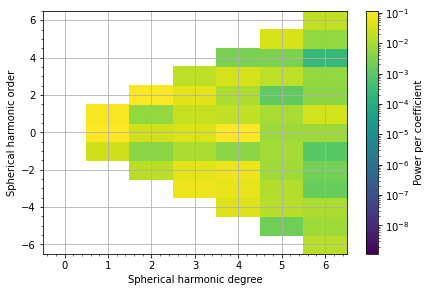

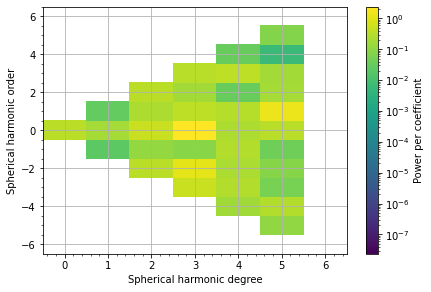

In [18]:
clms_dz = pyshtools.SHCoeffs.from_zeros(lmax=lmax,kind='complex',normalization=normalization)
C_dz = pyshtools.SHCoeffs.from_zeros(lmax=lmax,kind='complex',normalization=normalization)

if shtype == 'irr':
    clms_dz.coeffs[:,1:,:] = clms.coeffs[:,:-1,:]
    C_dz.set_coeffs(-C_dz_list, l_list + 1, m_list)
elif shtype == 'reg':
    clms_dz.coeffs[:,:-1,:] = clms.coeffs[:,1:,:]
    C_dz.set_coeffs(C_dz_list, l_list - 1, m_list)
else:
    print('invalid solid harmonics type (irr, reg)')

clms_dz.coeffs = clms_dz.to_array() * C_dz.to_array()

fig,ax = clms.plot_spectrum2d(vrange=(1e-8,1))#, vscale='lin')
fig,ax = clms_dz.plot_spectrum2d(vrange=(1e-8,1))#, vscale='lin')

#Ilms_dz = clm_dz.expand(lat=LAT, lon=LON)/R**(l_dz+1)
tic = time.time()
Ilms_dz = eval_GridC(clms_dz, LAT, LON, R, shtype=shtype)
tIlms_dz = time.time() - tic

Calculate $D_1$ and $D_2$ direction gradients:

[1 1 2 2 3 3 4 4 5 5 6 6]
[-1  0 -2 -1 -3 -2 -4 -3 -5 -4 -6 -5]


/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2068: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, :lmax] = _np.fliplr(mnegative)[:, :lmax]
/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2069: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, lmax:] = mpositive


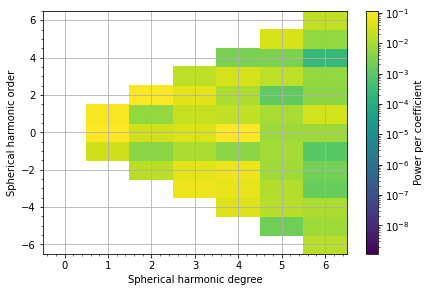

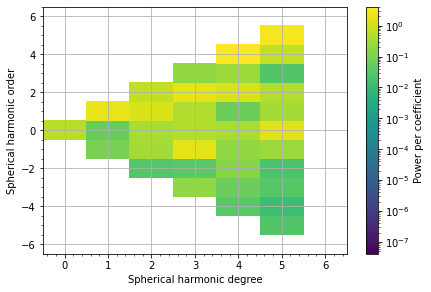

In [19]:
clms_d1 = pyshtools.SHCoeffs.from_zeros(lmax=lmax,kind='complex',normalization=normalization)
C_d1 = pyshtools.SHCoeffs.from_zeros(lmax=lmax,kind='complex',normalization=normalization)

if shtype == 'irr':
    clms_d1.coeffs[0,1:,:-1] = clms.coeffs[0,:-1,1:]
    clms_d1.coeffs[1,1:,1:] = clms.coeffs[1,:-1,:-1]
    clms_d1.coeffs[1,1:,1] = clms.coeffs[0,:-1,0]
    C_d1.set_coeffs(C_d1_list, l_list + 1, m_list - 1)
elif shtype == 'reg':
    clms_d1.coeffs[0,:-1,:-1] = clms.coeffs[0,1:,1:]
    clms_d1.coeffs[1,:-1,1:] = clms.coeffs[1,1:,:-1]
    clms_d1.coeffs[1,:-1,1] = clms.coeffs[0,1:,0]
    valid_idx = l_d >= np.abs(m_list - 1)
    print(l_list[np.logical_not(valid_idx)])
    print(m_list[np.logical_not(valid_idx)])
    C_d1.set_coeffs(C_d1_list[valid_idx], l_list[valid_idx] - 1, m_list[valid_idx] - 1)
else:
    print('invalid solid harmonics type (irr, reg)')
    
clms_d1.coeffs = clms_d1.to_array() * C_d1.to_array()

#print(clms_d1.to_array())
fig,ax = clms.plot_spectrum2d(vrange=(1e-8,1))#, vscale='lin')
fig,ax = clms_d1.plot_spectrum2d(vrange=(1e-8,1))#, vscale='lin')

#Ilms_d1 = clm_d1.expand(lat=LAT, lon=LON)/R**(l_d1+1)
tic = time.time()
Ilms_d1 = eval_GridC(clms_d1, LAT, LON, R, shtype=shtype)
tIlms_d1 = time.time() - tic

6
[1 1 2 2 3 3 4 4 5 5 6 6]
[0 1 1 2 2 3 3 4 4 5 5 6]


/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2068: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, :lmax] = _np.fliplr(mnegative)[:, :lmax]
/usr/local/lib/python3.6/dist-packages/pyshtools/shclasses/shcoeffsgrid.py:2069: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, lmax:] = mpositive


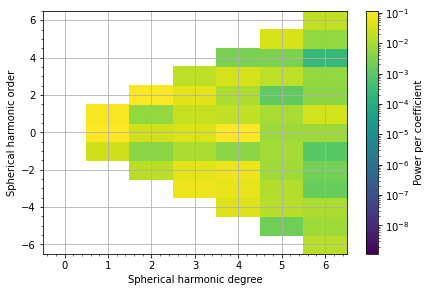

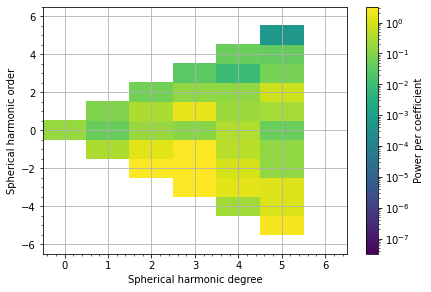

In [20]:
clms_d2 = pyshtools.SHCoeffs.from_zeros(lmax=lmax,kind='complex',normalization=normalization)
C_d2 = pyshtools.SHCoeffs.from_zeros(lmax=lmax,kind='complex',normalization=normalization)
print(lmax)
if shtype == 'irr':
    clms_d2.coeffs[0,1:,1:] = clms.coeffs[0,:-1,:-1]
    clms_d2.coeffs[1,1:,:-1] = clms.coeffs[1,:-1,1:]
    clms_d2.coeffs[0,1:,0] = clms.coeffs[1,:-1,1]
    C_d2.set_coeffs(-C_d2_list, l_list + 1, m_list + 1)
elif shtype == 'reg':
    clms_d2.coeffs[0,:-1,1:] = clms.coeffs[0,1:,:-1]
    clms_d2.coeffs[1,:-1,:-1] = clms.coeffs[1,1:,1:]
    clms_d2.coeffs[0,:-1,0] = clms.coeffs[1,1:,1]
    valid_idx = l_d >= np.abs(m_list + 1)
    print(l_list[np.logical_not(valid_idx)])
    print(m_list[np.logical_not(valid_idx)])
    C_d2.set_coeffs(-C_d2_list[valid_idx], l_list[valid_idx] - 1, m_list[valid_idx] + 1)
else:
    print('invalid solid harmonics type (irr, reg)')

clms_d2.coeffs = clms_d2.to_array() * C_d2.to_array()

fig,ax = clms.plot_spectrum2d(vrange=(1e-8,1))#, vscale='lin')
fig,ax = clms_d2.plot_spectrum2d(vrange=(1e-8,1))#, vscale='lin')

#Ilms_d2 = clm_d2.expand(lat=LAT, lon=LON)/R**(l_d2+1)
tic = time.time()
Ilms_d2 = eval_GridC(clms_d2, LAT, LON, R, shtype=shtype)
tIlms_d2 = time.time() - tic

In [21]:
dIlms_num_1 = dIlms_num[0] - 1.0j*dIlms_num[1]
dIlms_num_2 = dIlms_num[0] + 1.0j*dIlms_num[1]
Cds1 = (Ilms_d1/dIlms_num_1)
Cds2 = (Ilms_d2/dIlms_num_2)
Cdsz = (Ilms_dz/dIlms_num[2])

errd1s = np.abs(np.abs(Cds1).mean() - 1)
errd2s = np.abs(np.abs(Cds2).mean() - 1)
errdzs = np.abs(np.abs(Cdsz).mean() - 1)
print(errdzs, errd1s, errd2s)
Testdzs = errdzs < 1e-2
Testd1s = errd1s < 1e-2
Testd2s = errd2s < 1e-2
if Testdzs:
    print('Multiple mode analytical dIlm/dz is close to numerical results, time: %.2fs'%(tIlms_dz))
else:
    print('Multiple mode analytical dIlm/dz is incorrect, rel. err.: %.8f, time: %.2fs'%(errdzs, tIlms_dz))
if Testd1s:
    print('Multiple mode analytical dIlm/d1 is close to numerical results, time: %.2fs'%(tIlms_d1))
else:
    print('Multiple mode analytical dIlm/d1 is incorrect, rel. err.: %.8f, time: %.2fs'%(errd1s, tIlms_d1))
if Testd2s:
    print('Multiple mode analytical dIlm/d2 is close to numerical results, time: %.2fs'%(tIlms_d2))
else:
    print('Multiple mode analytical dIlm/d2 is incorrect, rel. err.: %.8f, time: %.2fs'%(errd2s, tIlms_d2))

4.785507082494256e-05 3.1300661781807904e-05 9.163090504882287e-05
Multiple mode analytical dIlm/dz is close to numerical results, time: 5.39s
Multiple mode analytical dIlm/d1 is close to numerical results, time: 5.37s
Multiple mode analytical dIlm/d2 is close to numerical results, time: 5.38s


Then we implement the Hobson's differentiation into `shgrad.py`, and we do the test here:

In [22]:
x = 1; y = 1; z = 1;
r = np.sqrt(x**2 + y**2 + z**2)
colat = np.arccos(z/r)
lon = np.arctan2(y,x)
lat_d = 90-colat/np.pi*180 # latitude in degree
lon_d = lon/np.pi*180      # longitude in degree
print(lat_d,lon_d)

35.26438968275466 45.0


In [23]:
from shelastic.shgrad import VSH2

for l in range(1,6):
    for m in range(-l,l+1):
        Ylm = pyshtools.SHCoeffs.from_zeros(lmax=lmax,kind='complex',normalization=normalization)
        Ylm.set_coeffs(1.0, l, m)
        #print(Ylm.lmax)
        Psilm = VSH2(Ylm.to_array(), norm=Ylm.normalization, csphase=Ylm.csphase)
        ylm_x_val = pyshtools.expand.MakeGridPointC(Psilm[...,0],lat_d,lon_d)
        ylm_y_val = pyshtools.expand.MakeGridPointC(Psilm[...,1],lat_d,lon_d)
        ylm_z_val = pyshtools.expand.MakeGridPointC(Psilm[...,2],lat_d,lon_d)
        #Ylm_x, Ylm_y, Ylm_z = VSH2(Ylm)
        #Ylm_x, Ylm_y, Ylm_z = SHgradClm_VSH(Ylm)
        #Ylm_x, Ylm_y, Ylm_z = SHgrad(l, m, lmax, r)
        #ylm_x_val = pyshtools.expand.MakeGridPointC(Ylm_x.to_array(),lat_d,lon_d)
        #ylm_y_val = pyshtools.expand.MakeGridPointC(Ylm_y.to_array(),lat_d,lon_d)
        #ylm_z_val = pyshtools.expand.MakeGridPointC(Ylm_z.to_array(),lat_d,lon_d)
        np.set_printoptions(precision=4,suppress=True)
        print('dy_'+str(l)+'^'+str(m)+' =', 1/r*np.array([ylm_x_val,ylm_y_val,ylm_z_val]))

dy_1^-1 = [-0.4714-0.2357j  0.2357+0.4714j  0.2357-0.2357j]
dy_1^0 = [-0.3333+0.j -0.3333+0.j  0.6667+0.j]
dy_1^1 = [ 0.4714-0.2357j -0.2357+0.4714j -0.2357-0.2357j]
dy_2^-2 = [ 0.9129-0.3043j -0.9129-0.3043j -0.    +0.6086j]
dy_2^-1 = [-0.3043-0.6086j  0.6086+0.3043j -0.3043+0.3043j]
dy_2^0 = [-0.7454+0.j -0.7454+0.j  1.4907+0.j]
dy_2^1 = [ 0.3043-0.6086j -0.6086+0.3043j  0.3043+0.3043j]
dy_2^2 = [ 0.9129+0.3043j -0.9129+0.3043j -0.    -0.6086j]
dy_3^-3 = [-0.5693+1.1386j  1.1386-0.5693j -0.5693-0.5693j]
dy_3^-2 = [ 1.3944+0.j -1.3944+0.j  0.    +0.j]
dy_3^-1 = [ 0.441 -0.8819j  0.8819-0.441j  -1.3229+1.3229j]
dy_3^0 = [-0.5092+0.j -0.5092+0.j  1.0184+0.j]
dy_3^1 = [-0.441 -0.8819j -0.8819-0.441j   1.3229+1.3229j]
dy_3^2 = [ 1.3944-0.j -1.3944-0.j  0.    -0.j]
dy_3^3 = [ 0.5693+1.1386j -1.1386-0.5693j  0.5693-0.5693j]
dy_4^-4 = [-0.4648-1.3944j -0.4648+1.3944j  0.9296+0.j    ]
dy_4^-3 = [-1.3147+1.6434j  1.6434-1.3147j -0.3287-0.3287j]
dy_4^-2 = [ 1.0541+0.8784j -1.0541+0.8784j  0.   

Now we completely recovered the `SHgrad_VSH` by our new method.

### Test result

In [24]:
if Testd1 and Testd2 and Testdz:
    print('passed test for single mode gradient: grad(Ilm)')
else:
    print('test failed for single mode gradient: grad(Ilm)')
if Testd1s and Testd2s and Testdzs:
    print('passed test for multiple mode gradient: grad(sum(Clm Ilm))')
else:
    print('test failed for multiple mode gradient: grad(sum(Clm Ilm))')

passed test for single mode gradient: grad(Ilm)
passed test for multiple mode gradient: grad(sum(Clm Ilm))
